In [ ]:
# Importing libraries and modules
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools

import time
from zipfile import ZipFile
from io import BytesIO
from urllib import request
import sqlite3

from statsmodels.stats.weightstats import ttest_ind as ttest

from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import datasets, metrics

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

import umap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# // 1. Research Question

Here we will be analyzing and modeling longitudinal test score data from the [Campus Recruitment](https://www.kaggle.com/benroshan/factors-affecting-campus-placement) dataset from Kaggle. We'll be seeing if it's possible to generate meaningful clusters of students based on the score data that we have, and if these clusters give us any meaningful information in terms of which MBA students are more or likely to get job placements. 

# // 2. Defining Functions

This function transforms the scaled X features into two principal components. The datapoints are classified by the label the model applied to each data point. On each new model `scatter_clusters()` is run on, the spread and location of the points won't vary, because PCA's fit and transformation aren't dependent on model choice.

Therefore we can see precisely the differences among the models of (a) what number of clusters was optimum for the model, represented by the number of colors in the visualization, and (b) how the model labeled the points. We can compare this with the ARI score and Silhouette Score derived in the following cell to get a feel for why the model is performing the way it is on those metrics.

In [ ]:
def scatter_clusters(X, labels, title):
  pca = PCA(n_components=2).fit_transform(X)
  components = pd.DataFrame(pca,
                            columns=list(range(1, 3)))
  
  plt.figure(figsize=(7,5))

  sns.scatterplot(x=components[1],
                  y=components[2],
                  hue=labels)
  plt.title(title)
  plt.ylabel('PC2')
  plt.xlabel('PC1')
  plt.show()

`results()` produces three visualizations:
* 1. A bar graph comparing the relative importances of each feature in determining the cluster boundaries
* 2. Violin plots of each cluster to show the precise composition of each cluster for each feature
* 3. A bar graph of the average placement rate for each cluster. This basically identifies how predictive the clusters are for student job placement.

In [ ]:
def results(labels, cluster_var, name):

  # Horizonal bar graph for feature importance
  X_sorted = pd.DataFrame(
      {'feature': X.columns,
      'F': f_classif(X_scaled, labels)[0],
      'p': f_classif(X_scaled, labels)[1]
      }
  )
  X_sorted.sort_values(by='F', inplace=True, ascending=False)
  X_sorted.index = range(len(X_sorted.index))

  plt.figure(figsize=(10,10))

  sns.barplot(y=X_sorted.feature,
              x=X_sorted.F)
  plt.title('Features sorted by relevance to {} cluster differences'.format(name))
  plt.show()

  # Violin plots
  plt.figure(figsize=(20,10))

  for i in range(5):

      plt.subplot(2,3,i+1)

      sns.violinplot(y=X_sorted.feature[i],
                    x=cluster_var,
                    data=named_data)
      plt.title(X_sorted.feature[i])
      plt.ylabel('')
      plt.xlabel('')

  plt.suptitle('Top 10 Feature Differences Among {} Clusters'.format(name))
  plt.show()

  print('\n')

  # Average placement by cluster
  cluster_ratios = []

  for cluster in list(named_data[cluster_var].unique()):

      num_placements = named_data[named_data[cluster_var] == cluster].placed_label.sum()
      ratio_placements = num_placements / len(named_data[named_data[cluster_var] == cluster])
      cluster_ratios.append(ratio_placements)

  splot = sns.barplot(y=cluster_ratios,
                      x=list(named_data[cluster_var].unique()))
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
  plt.ylabel('Percent Placed')
  plt.title('Student Placement by Cluster')
  plt.show()

**Brief Summary of Metrics**

The two main metrics we'll use to assess clusters are Ajusted Rand Index and Silhouette Scores.

The **Rand Index** is a way of assessing how well the clustering model is performing if we have labels for the dataset. In this case we do: the `placed` column, which is a 0/1 binary feature. This means it's mostly likely, but not necessarily the case, that the highest performing models will produce two clusters. Because we're assessing the models based on *known true values*, cases where we're assessing Rand Index can be understood as semi-supervised learning models.

The way Rand works, basically, is that it divides the number of points that the model clusters correctly according to the preexisting labels by the total number of points in the dataset. So if the score is 1, that means it was perfect. If it's a 0, that means it misclassified every single point (kind of remarkable in itself). So in a case where we have a binary label, a 0.5 Rand Index score represents how we'd do according to a coin toss. Anything better than 0.5 is better than dumb luck, and anything smaller than 0.5 is *worse* than dumb luck.

"ARI" refers to an "adjusted" Rand Index that rescales the index from -1 to 1, with a model that performs as well as a coin toss landing in the middle at 0. It does this by substracting the expected RI from a totally random model (in the case of our binary labels, 0.5) from the numerator and denominator.

If we're doing true, totally unsupervised learning, ARI won't work. That's when we need to look at **Silhouette Scores**. In our case, we can look at both. Silhouette basically looks at how cohesive or distinct each cluster is, in a word, how much the clusters look like, well ... clusters. So it should be pretty easy to tell the difference between visualizations of clusters with a high Silhouette Score and a low one.

Silhouette acheives this by taking the average distance between points within their clusters and subtracting it from the average distance between each point and all the points in the nearest other cluster. So if the clusters are really dense and far apart, that is, "cohesive," that difference will be big. If the clusters are looser and jumbled together, the difference will be smaller, or negative. The difference is then normalized by dividing it by the average distance from the points to all the points in the nearest cluster (or the average distance among points in the same cluster if that happens to be larger). That way we get scores close to -1 for really loose jumbled clusters and scores closer to +1 for tight, differentiated clusters.

** The function **

So the function below uses scikit-learn to calculate ARI and Silhouette for a given model and add those scores to a Pandas dataframe. Then it generates a bargraph for both metrics, so that each time the function is run on a model it compares the new metrics with the metrics of all the models it's already been run on. To do this the dataframe that's returned from the previous run has to be passed into the function as the `table` argument. The first time the function is run, `table` is set to an empty dataframe with columns for model, ARI, and Silhouette.

In [ ]:
table = pd.DataFrame(columns=['model', 'ari', 'silhouette'])

def ari_silhouette(X, y, labels, model_name, table=table, metric='euclidean'):

    ari = metrics.adjusted_rand_score(y, labels)
    sil = metrics.silhouette_score(X, labels, metric)

    table = table.append({'model':model_name,
                          'ari':ari,
                          'silhouette':sil},
                         ignore_index=True)
    
    plt.figure(figsize=(12,5))
    plt.subplot(121)

    ari_splot = sns.barplot(y=table.ari,
                            x=table.model)
    for p in ari_splot.patches:
      ari_splot.annotate(format(p.get_height(), '.3f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', 
                              xytext = (0, 9), 
                              textcoords = 'offset points')
    plt.title('ARI Scores')

    plt.subplot(122)
    sil_splot = sns.barplot(y=table.silhouette,
                            x=table.model)
    for p in sil_splot.patches:
      sil_splot.annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.title('Silhouette Scores')
    plt.show()

    return table

# // 3. Model Prep

## 3.1 Cleaning Data

The dataset we're using comes from the [Campus Recruitment](https://www.kaggle.com/benroshan/factors-affecting-campus-placement) dataset from Kaggle. As mentioned we'll be reconstructing the dataset to some degree into a simimulated dataset that's more directly interpretable for a decision-maker in a higher education context.

In [ ]:
# Reading in the dataframe from a GitHub repo
url = 'https://raw.githubusercontent.com/semblables/unsupcap/master/datasets_596958_1073629_Placement_Data_Full_Class.csv'
read_csv = pd.read_csv(url)

In [ ]:
# Setting this variable equal to a copy of the read csv allows us to 'reset'
# the dataset variable without reloading the data all over again.
raw_data = read_csv.copy()

In [ ]:
# Displaying columns so they can be assessed for renaming
raw_data.columns

Index(['sl_no', 'gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s',
       'degree_p', 'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p',
       'status', 'salary'],
      dtype='object')

In [ ]:
# Creating mapper for more interpretable columns names
column_names = {'sl_no': 'serial_num',
                'gender': 'gender',
                'ssc_p': 'percentage_9_10_grade',
                'ssc_b': 'board_of_education_9_10',
                'hsc_p': 'percentage_11_12_grade',
                'hsc_b': 'board_of_education_11_12',
                'hsc_s': 'college_degree_type',
                'degree_p': 'percentage_college',
                'degree_t': 'college_degree',
                'workex': 'work_experience_label',
                'etest_p': 'percentage_employability_test',
                'mba_p': 'percentage_mba',
                'status': 'placed',
                'salary': 'salary'}

In [ ]:
# Renaming columns
named_data = raw_data.rename(column_names, axis=1)

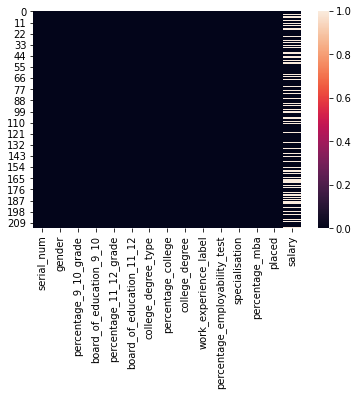

In [ ]:
# Checking dataframe visually for missing values
sns.heatmap(named_data.isnull())

In [ ]:
# Looks like 'salary' has missing values. Let's see how many.
print('Percent missing values in salary: {:.2%}'
      .format(named_data.salary.isnull().sum()/len(named_data)))

Percent missing values in salary: 31.16%


Typically we'd want to drop a column with over 20% missing values, but let's dig in to see if there's a reason so many values are missing. We see there's also a `placed` feature, so it's possible that there are values in `salary` only for those rows/students who were placed. Let's see what the ratio for placed students is.

In [ ]:
# Displaying ratio of non-placed students to total
print('Percent students not placed: {:.2%}'
      .format(len(named_data[named_data.placed == 'Not Placed'])/len(named_data)))

Percent students not placed: 31.16%


Looks like our guess was correct! So we also have no mising values in `salary` *for those students who were placed in jobs*. 

In [ ]:
# Resetting strings for integers for our target feature.
# 1 = 'Placed'; 0 = 'Not Placed'
named_data['placed_label'] = list(map(lambda element:
                                      1 if element == 'Placed'
                                      else 0,
                                      named_data.placed))

## 3.2 Exploring Data

Before developing models we want to see how much variety there is among our features that have continuous data. Clustering can still be meaningful if the features are highly colinear (have a high degree of correlation, basically different versions of the same theme), but as we can see below, the features aren't showing much correlation.

In [ ]:
continuous_features = ['percentage_9_10_grade', 'percentage_11_12_grade',
                       'percentage_college', 'percentage_employability_test',
                       'percentage_mba', 'high_school_college_diff']

named_data[continuous_features].corr()

,percentage_9_10_grade,percentage_11_12_grade,percentage_college,percentage_employability_test,percentage_mba,high_school_college_diff
percentage_9_10_grade,1.000000,0.511472,0.538404,0.261993,0.388478,0.158609
percentage_11_12_grade,0.511472,1.000000,0.434206,0.245113,0.354823,0.757948
percentage_college,0.538404,0.434206,1.000000,0.224470,0.402364,-0.258509
percentage_employability_test,0.261993,0.245113,0.224470,1.000000,0.218055,0.100305
percentage_mba,0.388478,0.354823,0.402364,0.218055,1.000000,0.089135
high_school_college_diff,0.158609,0.757948,-0.258509,0.100305,0.089135,1.000000


We can get a more granular view by looking at scatterplots of all the features stacked agaist each other. We've also colored the data points according to whether the student was placed in a job, and we can already see that the groups are clustering visually to some degree in many of the feature stack-ups.

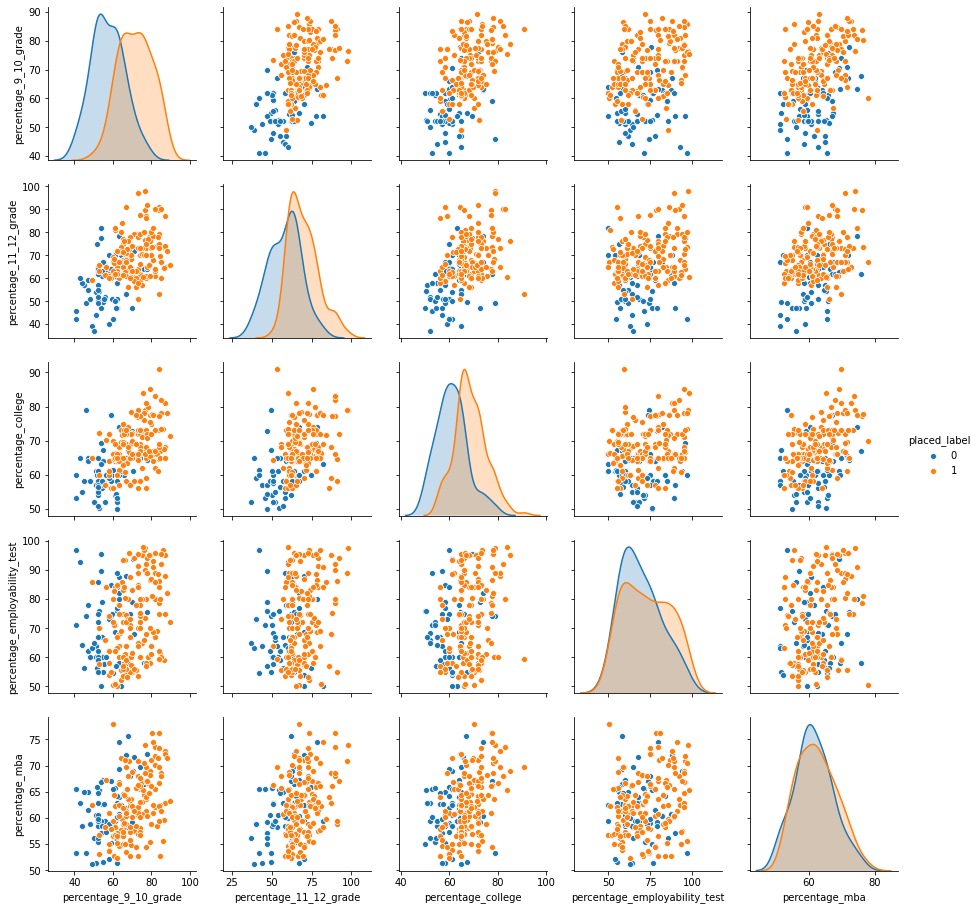

In [ ]:
sns.pairplot(named_data[['percentage_9_10_grade',
                'percentage_11_12_grade',
                'percentage_college',
                'percentage_employability_test',
                'percentage_mba',
                'placed_label']], hue='placed_label')

Considering the histogram plots, the grades for 9th & 10th grade seem to show the largest statistical difference between `placed` and `not placed` groups. We can find out more by conducting t-tests for each of our features to see if there's a statistically significant difference between the labels for each feature.

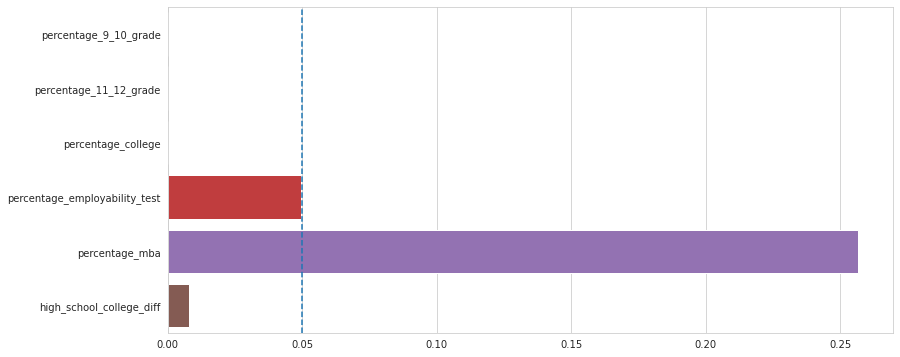

In [ ]:
pvals = []
for var in continuous_features:

    placed = named_data.loc[named_data.placed_label == 1, var]
    not_placed = named_data.loc[named_data.placed_label == 0, var]

    tstat, pval, df = (
        # Using ttest_ind from statsmodels for two-sample t-test
        ttest(placed,
              not_placed,
              alternative='two-sided', # Takes alternative hypothesis that 
                                       # difference in means not equal to value.
              usevar='unequal' # Standard deviations of samples not assumed
                               # to be the same.
              ))
    pvals.append(pval)

plt.figure(figsize=(13,6))
bplot = sns.barplot(y=continuous_features,
           x=pvals)
# Available code to set x-scale to log
#bplot.set_xscale("log")
plt.axvline(.05, linestyle='--')

So from a first look based on a two-sample t-test, we can't see any statistically significant difference on job placement in terms of MBA scores (`percentage_mba`). The employability test just barely makes the cut — looking at the histogram, there does visually seem to be some difference, though it makes sense the p-value isn't stellar. The other values are far too small to even make it onto our visualization, so we know there is certainly a statistical difference between the samples in terms of grades in high school and college.

Let's just dive one layer deeper to see if there's a role in the _interaction_ between the mba or employability scores and any of the other scores.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:850: RuntimeWarning: invalid value encountered in double_scalars
  z1 = (sem1 / semsum)**2 / (d1.nobs - 1)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:851: RuntimeWarning: invalid value encountered in double_scalars
  z2 = (sem2 / semsum)**2 / (d2.nobs - 1)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:617: RuntimeWarning: divide by zero encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff


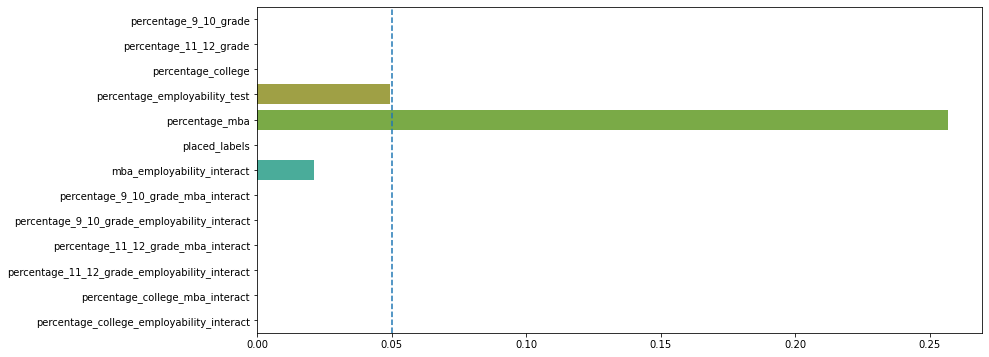

In [ ]:
# Creating separate df for interaction features
interaction_df = named_data[continuous_features].copy() # Coying to avoid
                                                        # SettingWithCopy warning
# Adding labels
interaction_df['placed_labels'] = named_data.placed_label

# Adding MBA / employability interaction variable
interaction_df['mba_employability_interact'] = (
    interaction_df.percentage_mba * interaction_df.percentage_employability_test
)

# Looping through high school and college grades to create
# interaction vars for mba and employability
for var in ['percentage_9_10_grade', 'percentage_11_12_grade',
                                          'percentage_college']:
    interaction_df[var+'_mba_interact'] = (
        named_data.percentage_mba * interaction_df[var])
    interaction_df[var+'_employability_interact'] = (
        named_data.percentage_employability_test * interaction_df[var])

# Running t-tests
pvals = []
for var in interaction_df.columns:

    placed = interaction_df.loc[interaction_df.placed_labels == 1, var]
    not_placed = interaction_df.loc[interaction_df.placed_labels == 0, var]

    tstat, pval, df = (
        # Using ttest_ind from statsmodels for two-sample t-test
        ttest(placed,
              not_placed,
              alternative='two-sided', # Takes alternative hypothesis that 
                                       # difference in means not equal to value.
              usevar='unequal' # Standard deviations of samples not assumed
                               # to be the same.
              ))
    pvals.append(pval)

plt.figure(figsize=(13,6))
bplot = sns.barplot(y=interaction_df.columns,
           x=pvals)
# Available code to set x-scale to log
#bplot.set_xscale("log")
plt.axvline(.05, linestyle='--')

From the visualization we can see that creating an interaction term created very statistically significant divergences in all cases where high school and college grades were involved. It seems that the difference between the samples completely carries through into the interaction term. What's more interesting is that the interaction term *between* the MBA score and the employability test score performed better than the employability test alone. So let's add this to the original dataframe and visualize it along with the others.

In [ ]:
# Creating interaction variable
named_data['mba_employability_interaction'] = (
    named_data.percentage_mba * named_data.percentage_employability_test
)
# Appending variable to 'continuous_features' list
if 'mba_employability_interaction' not in continuous_features:
  continuous_features.append('mba_employability_interaction')

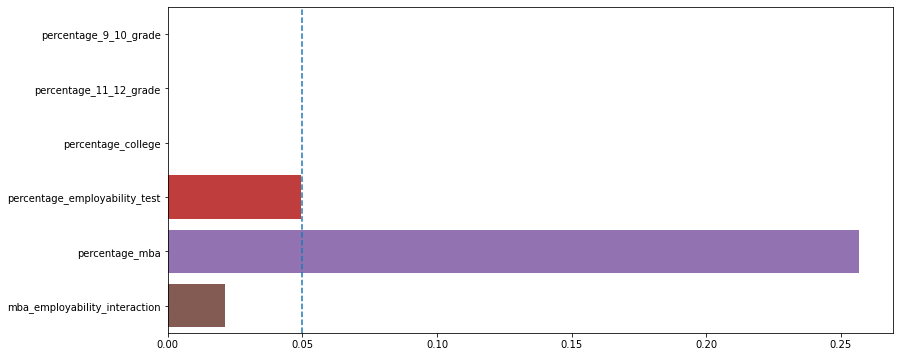

In [ ]:
# Collecting t-test p-values
pvals = []
for var in continuous_features:

    placed = named_data.loc[named_data.placed_label == 1, var]
    not_placed = named_data.loc[named_data.placed_label == 0, var]

    tstat, pval, df = (
        # Using ttest_ind from statsmodels for two-sample t-test
        ttest(placed,
              not_placed,
              alternative='two-sided', # Takes alternative hypothesis that 
                                       # difference in means not equal to value.
              usevar='unequal' # Standard deviations of samples not assumed
                               # to be the same.
              ))
    pvals.append(pval)

# Visualizing p-values
plt.figure(figsize=(13,6))
bplot = sns.barplot(y=continuous_features,
           x=pvals)
# (Available code to set x-scale to log)
# bplot.set_xscale("log")
plt.axvline(.05, linestyle='--')

In [ ]:
named_data['high_school_college_diff'] = named_data.percentage_11_12_grade - named_data.percentage_college

# // 4. Clustering Models

In [ ]:
# Loading the data from Sklearn's datasets
X = named_data[['percentage_9_10_grade',
                'percentage_11_12_grade',
                'percentage_college',
                'percentage_employability_test',
                'percentage_mba',
                'mba_employability_interaction',
                'high_school_college_diff']]
y = named_data.placed_label

# Standarizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4.1 K-Means

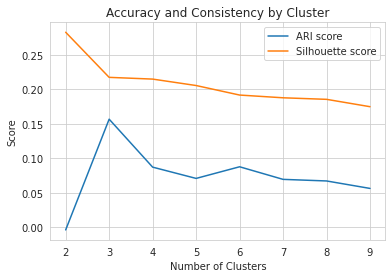

In [ ]:
k_vals = list(range(2,10))
ari_scores = []
silhouette_scores = []

for k in k_vals:
  labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)

  ari_score = metrics.adjusted_rand_score(y, labels)
  ari_scores.append(ari_score)

  silhouette_score = metrics.silhouette_score(X_scaled, labels, metric='euclidean')
  silhouette_scores.append(silhouette_score)

sns.set_style('whitegrid')
sns.lineplot(k_vals, ari_scores, label='ARI score')
sns.lineplot(k_vals, silhouette_scores, label='Silhouette score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Accuracy and Consistency by Cluster')
plt.legend()

In [ ]:
k_means_labels = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

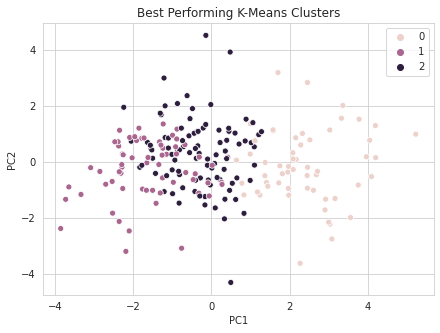

In [ ]:
scatter_clusters(X_scaled,
                 k_means_labels,
                 'Best Performing K-Means Clusters')

In [ ]:
named_data['kis3_clusters'] = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

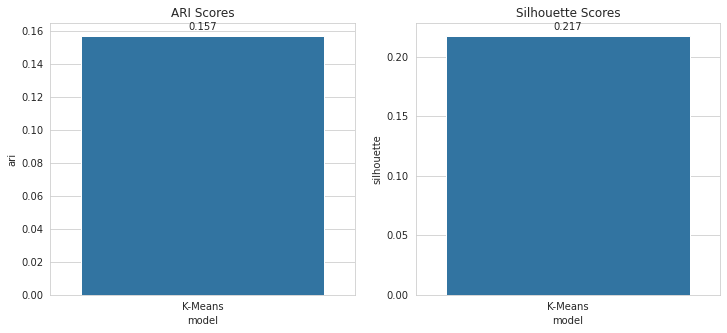

In [ ]:
scores_df_kmeans = ari_silhouette(X_scaled, y, k_means_labels, 'K-Means')

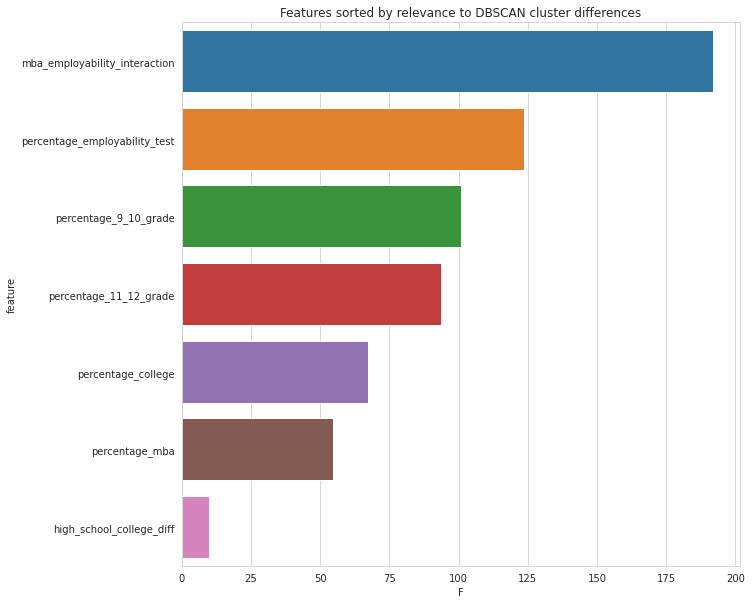

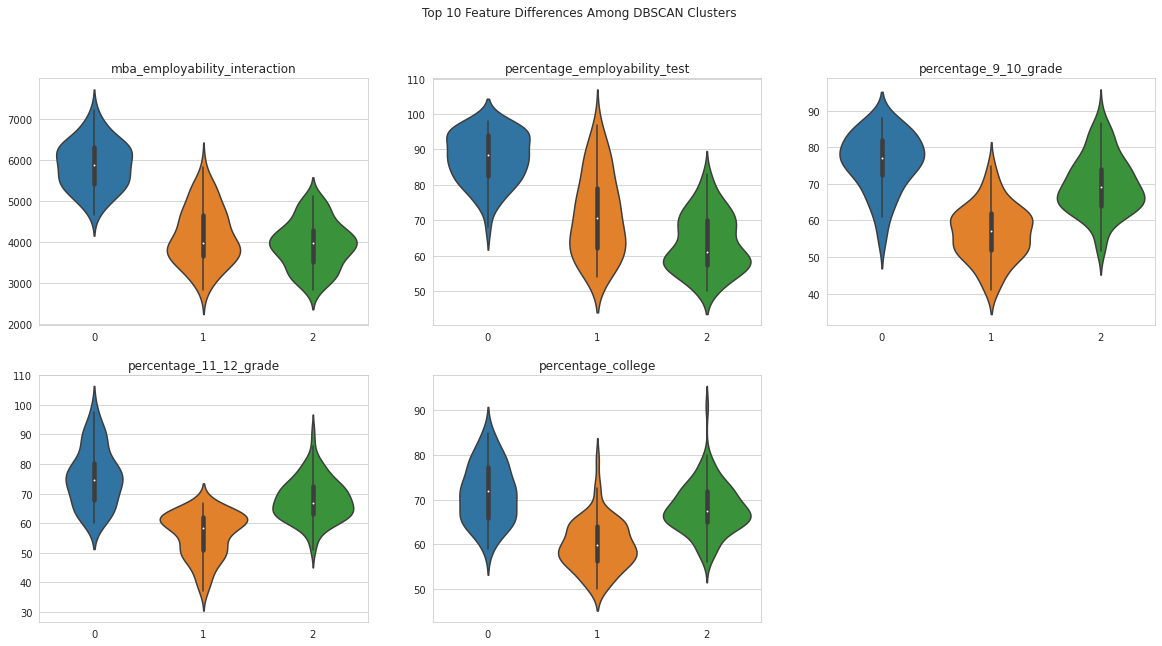

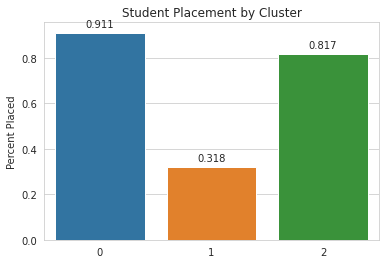

In [ ]:
results(k_means_labels, 'kis3_clusters', 'DBSCAN')

## 4.2 DBSCAN

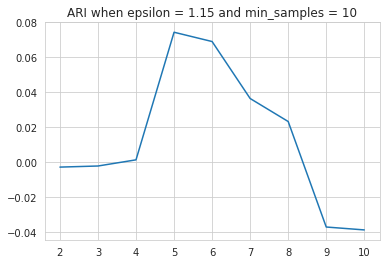

In [ ]:


min_samples = [2, 3, 4, 5, 6, 7, 8, 9, 10]
epsilon = 1.15
ari_scores = []
for min_sample in min_samples:
      dbscan_labels = DBSCAN(eps=epsilon, min_samples=min_sample).fit_predict(X_scaled)
      ari_score = metrics.adjusted_rand_score(y, dbscan_labels)

      ari_scores.append(ari_score)


sns.lineplot(min_samples, ari_scores)
plt.title('ARI when epsilon = {} and min_samples = {}'
          .format(epsilon, min_sample))
plt.show()

In [ ]:
dbscan_labels = DBSCAN(eps=1.15, min_samples=5).fit_predict(X_scaled)
pd.Series(dbscan_labels).value_counts()

 0    100
-1     94
 1     10
 2      7
 3      4
dtype: int64

In [ ]:
named_data['dbscan_clusters'] = dbscan_labels

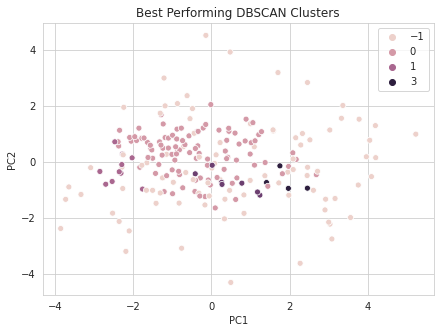

In [ ]:
scatter_clusters(X_scaled,
                 dbscan_labels,
                 'Best Performing DBSCAN Clusters')

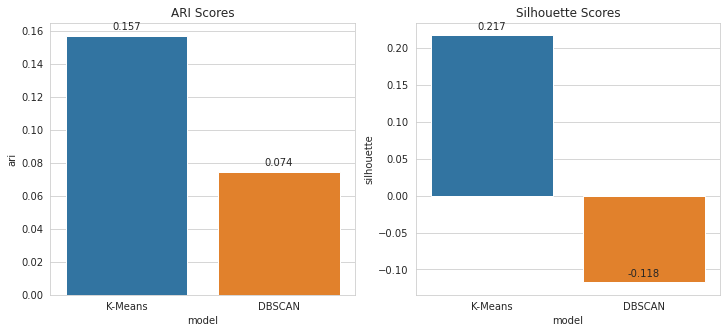

In [ ]:
scores_df_dbscan = ari_silhouette(X_scaled, y, dbscan_labels, 'DBSCAN', table=scores_df_kmeans)

In [ ]:
for cluster in list(range(-1,1)):
  num_placements = named_data[named_data.dbscan_clusters == cluster].placed_label.sum()
  ratio_placements = num_placements / len(named_data[named_data.dbscan_clusters == cluster])
  print('Ratio for cluster {}: {:.0%}'
        .format(cluster, ratio_placements))

Ratio for cluster -1: 60%
Ratio for cluster 0: 82%


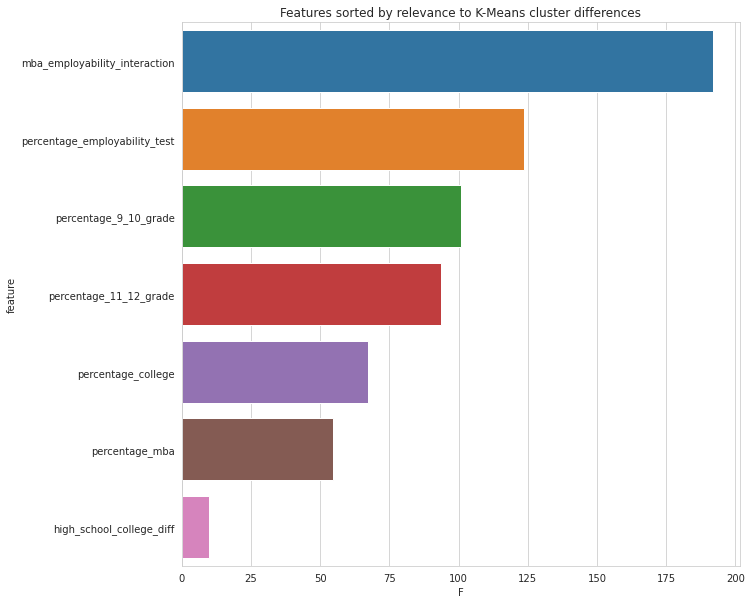

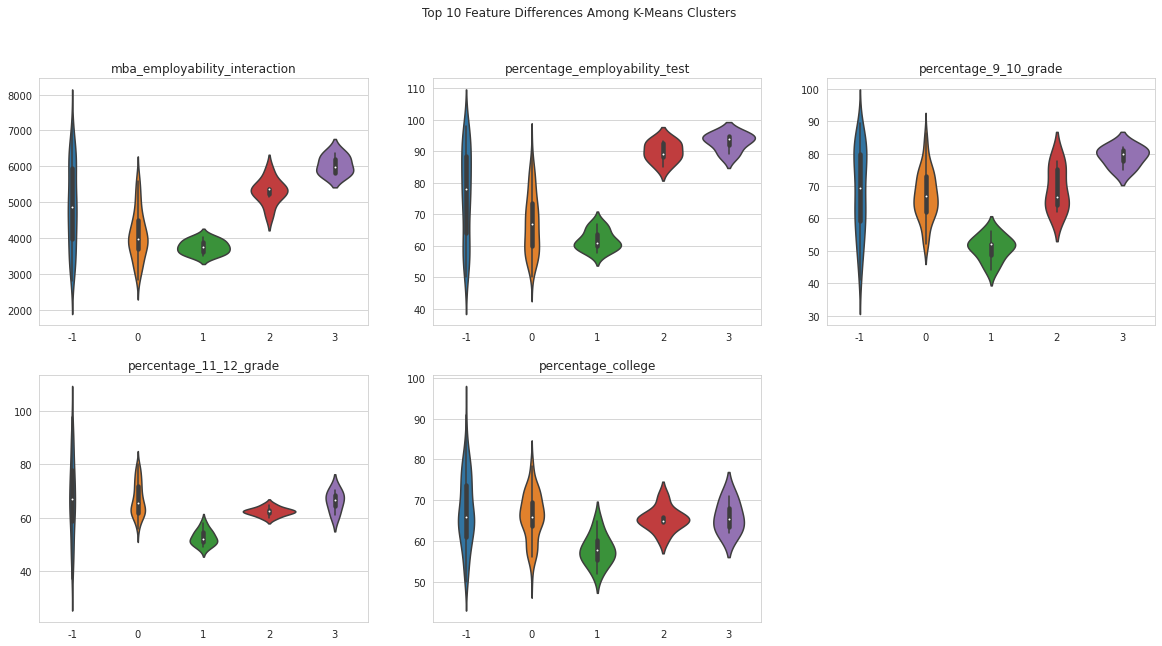

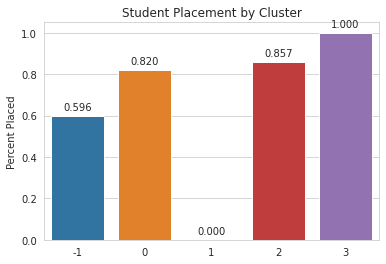

In [ ]:
results(k_means_labels, 'dbscan_clusters', 'K-Means')

## 4.3 Hierarchical Clustering

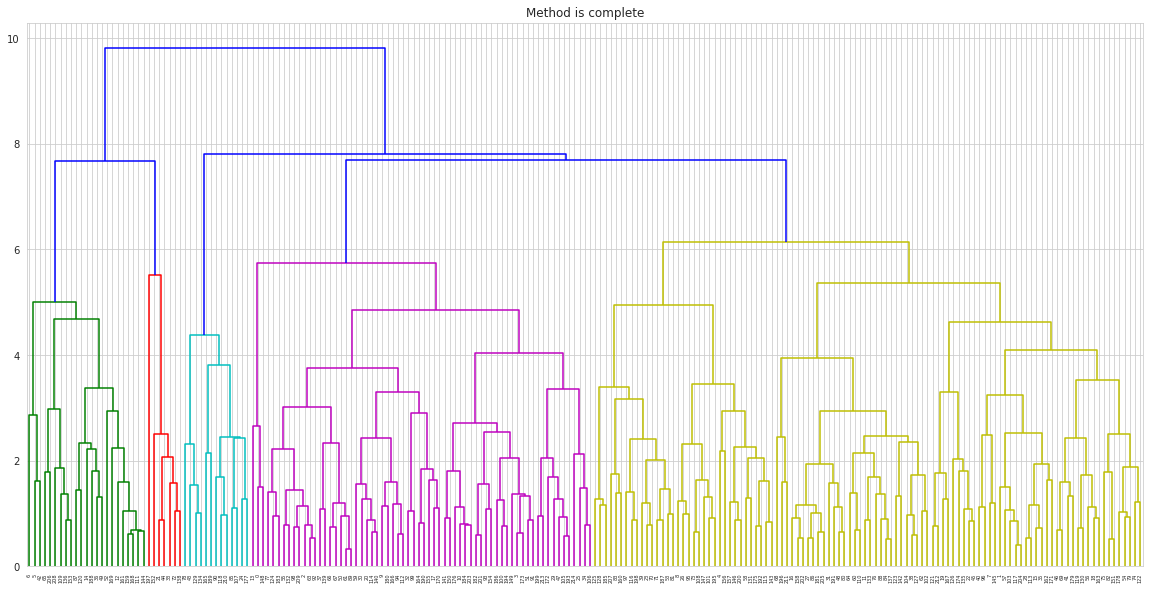

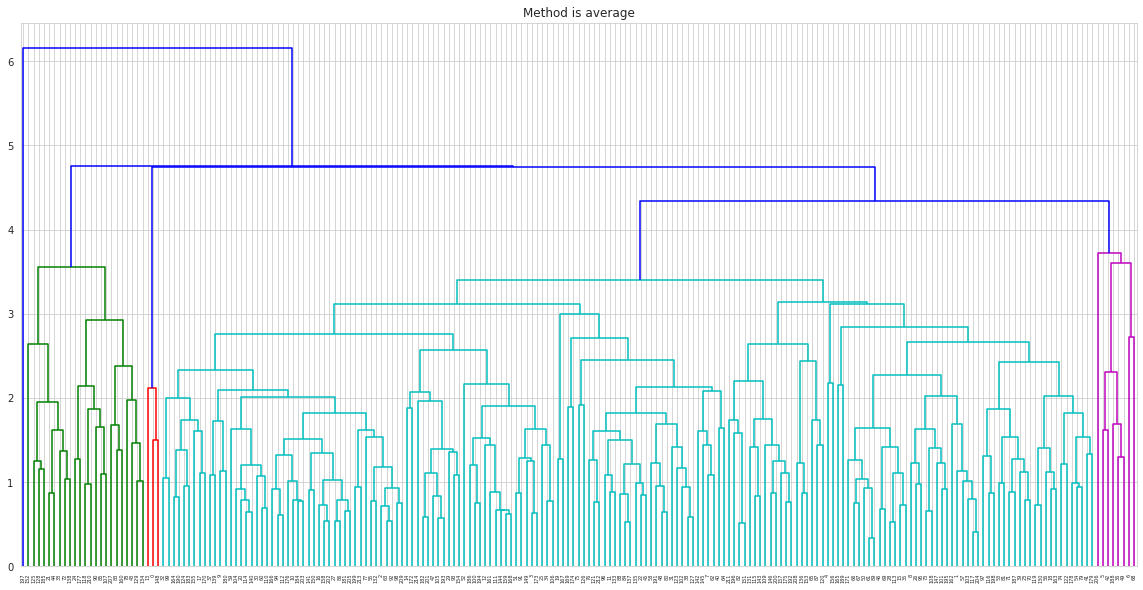

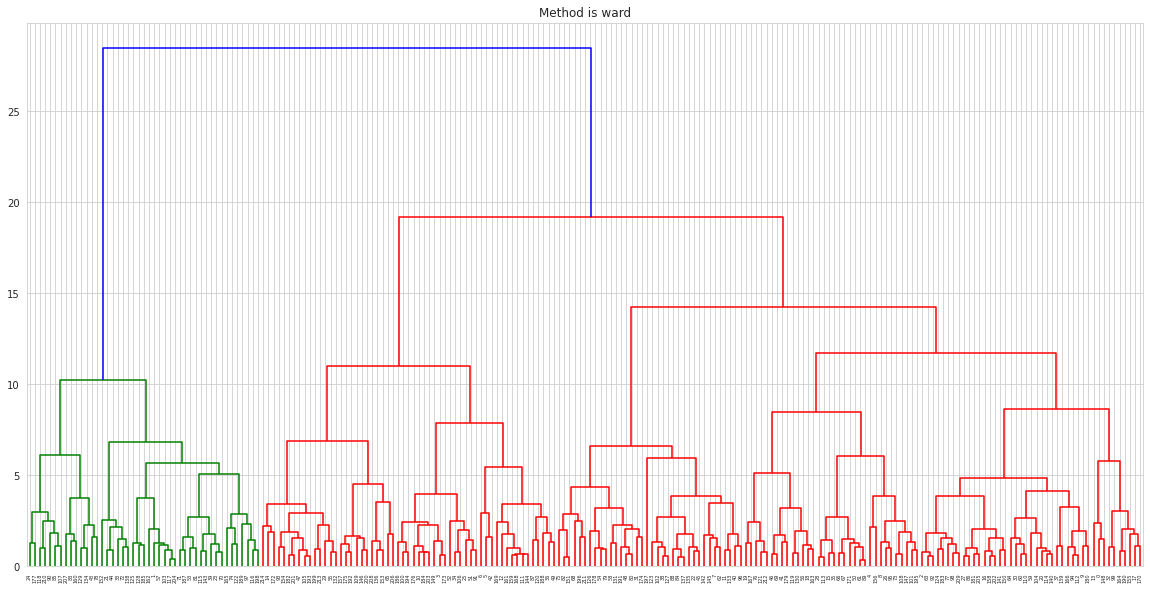

In [ ]:
# Producing dendrograms for the heart disease dataset using three
# different linkage methods: complete, average and ward
for method in ['complete', 'average', 'ward']:
    plt.figure(figsize=(20,10))
    plt.title('Method is '+method)
    dendrogram(linkage(X_scaled, method=method))
    plt.show()

In [ ]:
def agglomerative_clustering(X, linkage):
    ari_scores = []
    silhouette_scores = []
    for cluster_num in [2, 3, 4, 5, 6, 7]:
        clusters = AgglomerativeClustering(linkage=linkage, 
                                      affinity='euclidean',
                                      n_clusters=cluster_num
                                      ).fit_predict(X)

        ari_score = metrics.adjusted_rand_score(y,
                                                clusters)
        ari_scores.append(ari_score)

        silhouette_score = metrics.silhouette_score(X_scaled,
                                                    clusters,
                                                    metric='euclidean')
        silhouette_scores.append(silhouette_score)
    
    return ari_scores, silhouette_scores

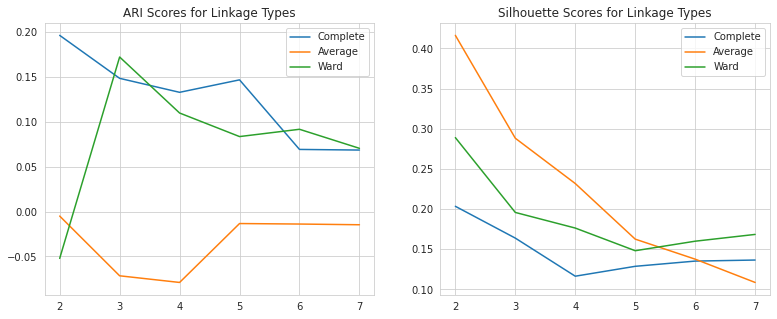

In [ ]:
complete_ari, complete_silhouette = agglomerative_clustering(X_scaled, 'complete')
average_ari, average_silhouette = agglomerative_clustering(X_scaled, 'average')
ward_ari, ward_silhouette = agglomerative_clustering(X_scaled, 'ward')

cluster_nums = [2, 3, 4, 5, 6, 7]

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.lineplot(cluster_nums, complete_ari, label='Complete')
sns.lineplot(cluster_nums, average_ari, label='Average')
sns.lineplot(cluster_nums, ward_ari, label='Ward')
plt.title('ARI Scores for Linkage Types')
plt.legend()

plt.subplot(122)
sns.lineplot(cluster_nums, complete_silhouette, label='Complete')
sns.lineplot(cluster_nums, average_silhouette, label='Average')
sns.lineplot(cluster_nums, ward_silhouette, label='Ward')
plt.title('Silhouette Scores for Linkage Types')
plt.legend()
plt.show()

The highest ARI score is with complete linkage type and 3 clusters. The corresponding Silhouette Score also outperforms Ward's Silhouette Score for two clusters and also for three clusters, where Ward's Silhouette Score peaks.

In [ ]:
# Creating model with complete linkage and 2 clusters
hierarchical_labels = (
    AgglomerativeClustering(linkage='complete', 
                            affinity='euclidean',
                            n_clusters=3
                            ).fit_predict(X_scaled)
)

named_data['hierarchical_clusters'] = hierarchical_labels

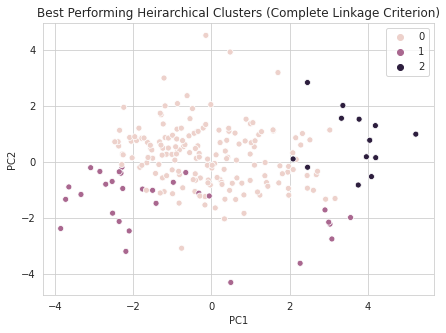

In [ ]:
scatter_clusters(X_scaled,
                 hierarchical_labels,
                 'Best Performing Heirarchical Clusters (Complete Linkage Criterion)')

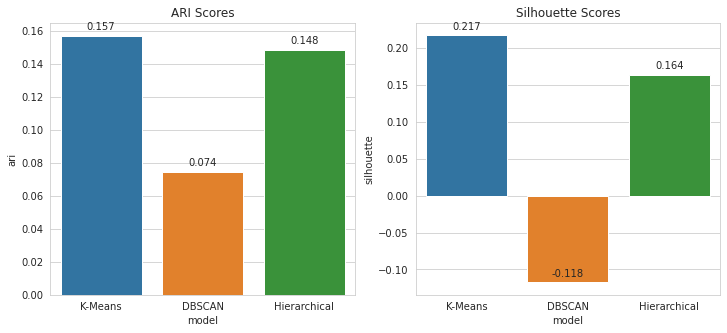

In [ ]:
scores_df_hierarchical = ari_silhouette(X_scaled, y, hierarchical_labels, 'Hierarchical', table=scores_df_dbscan)

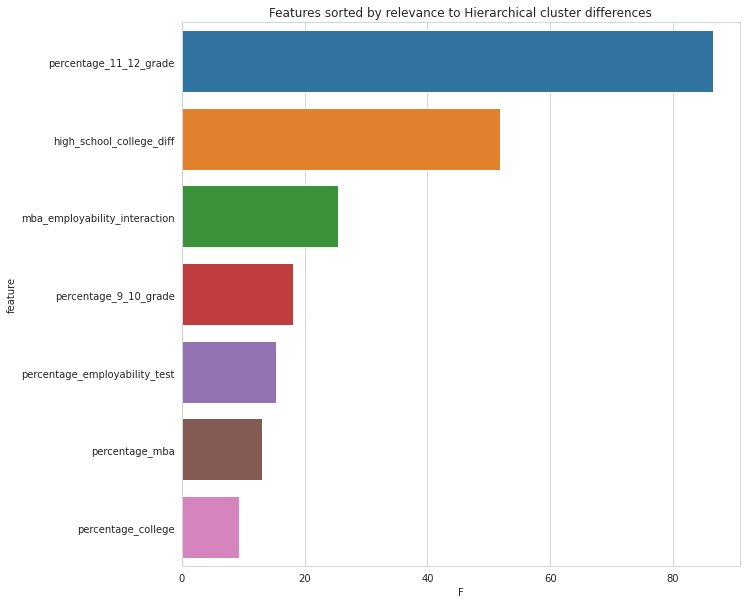

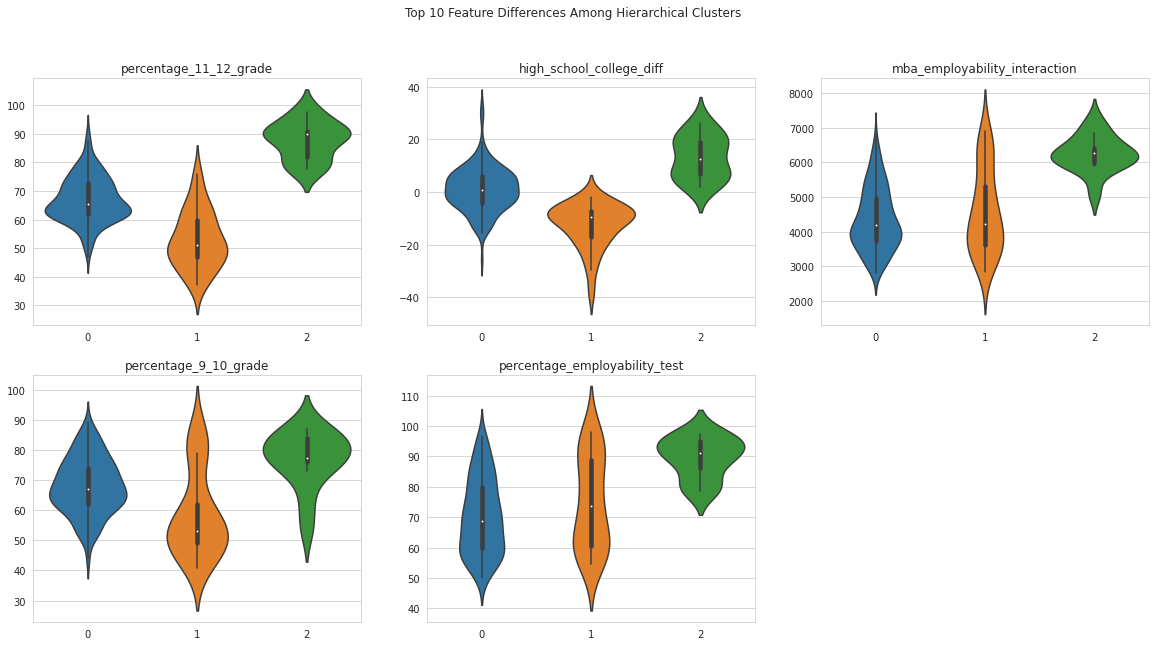

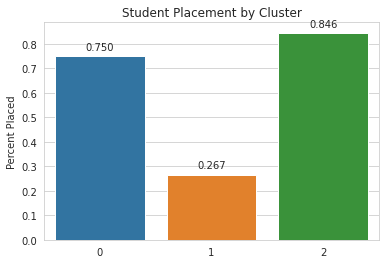

In [ ]:
results(hierarchical_labels,
        'hierarchical_clusters',
        'Hierarchical')

## 4.4 Gaussian Mixture Model

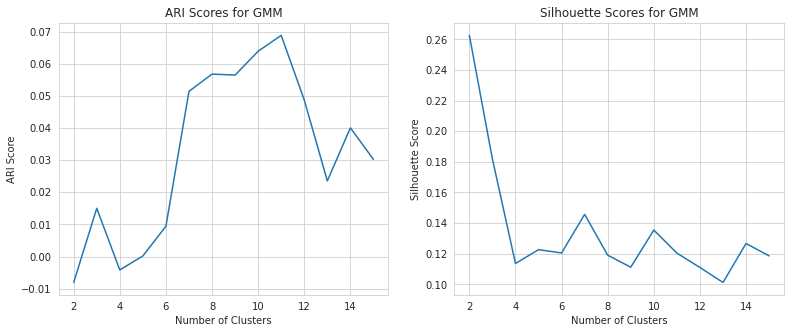

In [ ]:
ari_scores = []
silhouette_scores = []

clusters = list(range(2,16))

for n_cluster in clusters:
    gmm_labels = GaussianMixture(n_components=n_cluster,
                                 random_state=42).fit_predict(X_scaled)

    ari_score = metrics.adjusted_rand_score(y,
                                            gmm_labels)
    ari_scores.append(ari_score)

    silhouette_score = metrics.silhouette_score(X_scaled,
                                                gmm_labels,
                                                metric='euclidean')
    silhouette_scores.append(silhouette_score)

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.lineplot(clusters, ari_scores)
plt.title('ARI Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI Score')

plt.subplot(122)
sns.lineplot(clusters, silhouette_scores)
plt.title('Silhouette Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

This seems pretty interesting because ARI and Silhouette seem pretty inversely related. I'm curious what could account for this. The options seem to either choose 3 clusters, where there's a local peak for ARI and Silhouette hasn't completely collapsed, or to accept a low silhouette score and a higher ARI.


In [ ]:
# Maximizing ARI with a 11 cluster model
gmm_labels = GaussianMixture(n_components=11, random_state=42).fit_predict(X_scaled)

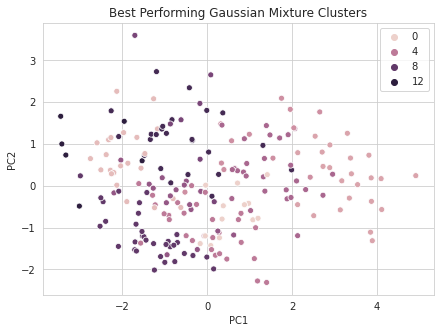

In [ ]:
scatter_clusters(X_scaled,
                 gmm_labels,
                 'Best Performing Gaussian Mixture Clusters')

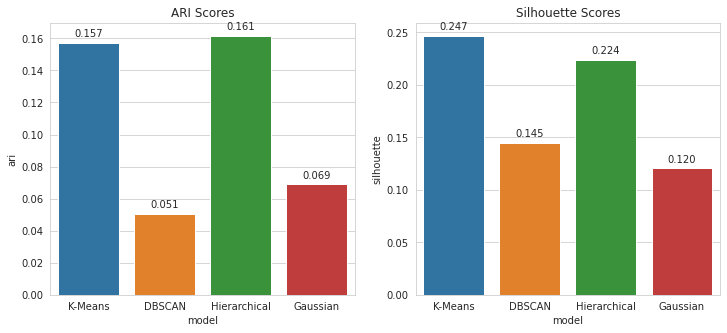

In [ ]:
scores_df_gmm = ari_silhouette(X_scaled, y, gmm_labels, 'Gaussian', table=scores_df_hierarchical)

Here we noticed that Gaussian still performed fairly well with it's Silhouette Score compared to other models, but it's peak ARI barely out performs DBSCAN.

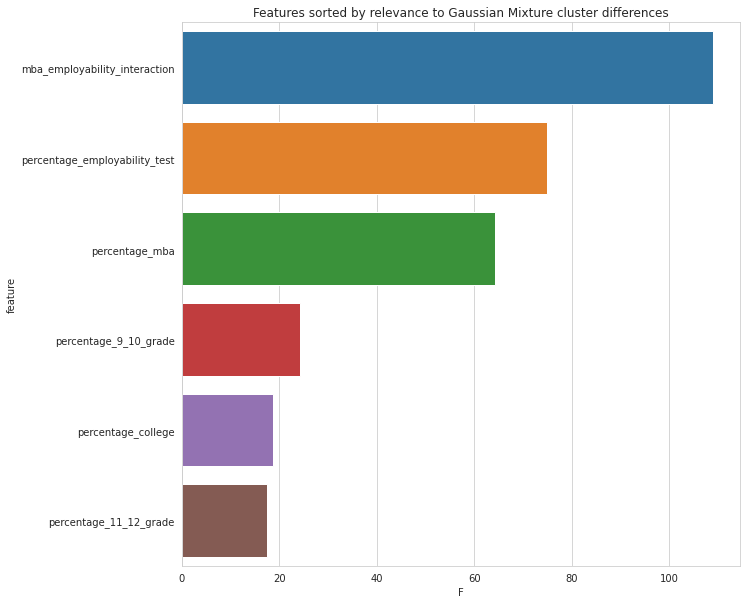

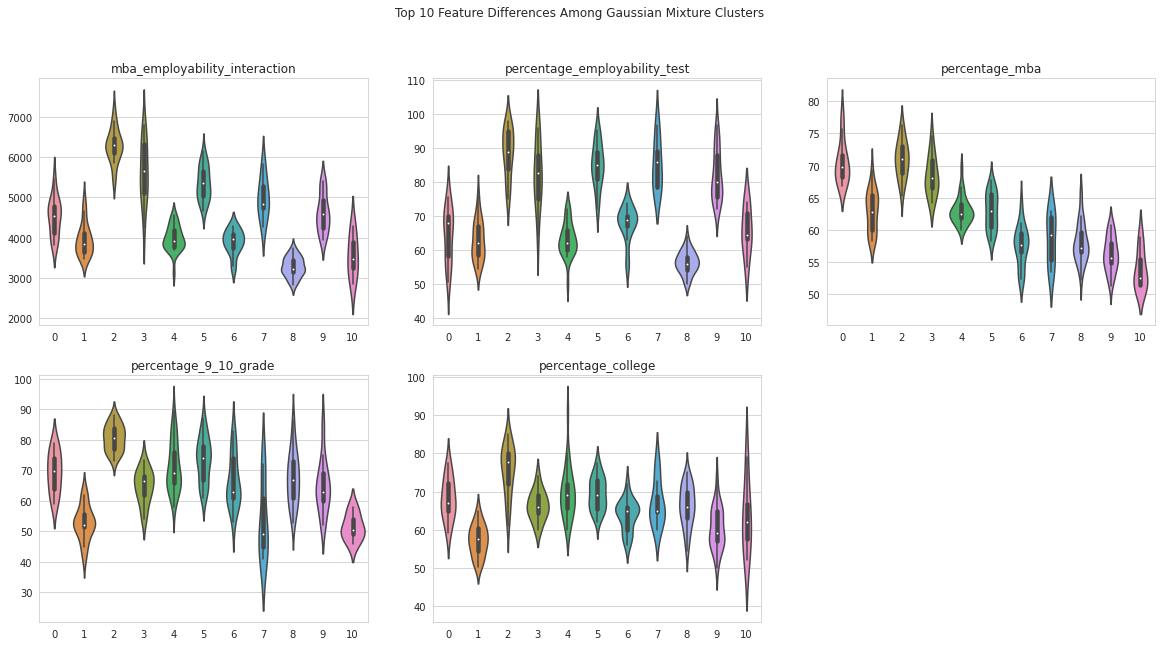

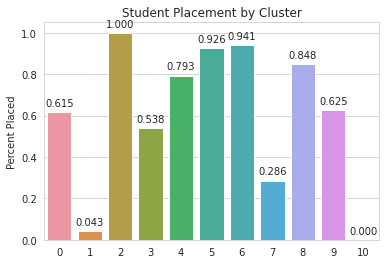

In [ ]:
named_data['gmm_clusters'] = gmm_labels

results(gmm_labels,
        'gmm_clusters',
        'Gaussian Mixture')

# // 5. Comparing Models

**5.1 ARI and Silhouette Metrics**

If we assess which model performs the best according to ARI and Silhouette, we'll need to go with **Hierarchical with the Complete linkage criterion** as well as **K-means with k=3**. Since correspondence to our target variable representing job placement is our primary objective, ARI is our primary metric, and on ARI hierarchical clustering and k-means significantly out perform the other models. Hierarchical slightly outperforms k-means on ARI, and k-means slightly outperforms hierarchical on silhouette.



**5.2 Interaction Variable and Feature Importance**

It's worth noting that the introduction of the MBA-Employability interaction variable significantly altered the clustering models. Hierarchical was previously the best performing model, but the Ward criterion performed best. K-means had a lower silhouette score, and GMM's silhouette score outperformed that of hierarchical clustering.

In every model, the interaction feature was the most important feature by a significant margin. This underlines the importance of exploring as deeply into the data on the first iteration in order to uncover hidden features in the data. This interaction feature wouldn't have been tried if t-tests hadn't been run on each feature. That's an additional sense in which this model is semi-supervised, because the features were analyzed in advance with regard to the labels.

The employability test seems to rank in second in terms of importance across the models, with a significant gap between it and the interaction variable. Both k-means and hierarchical clustering identify high school grades as more important than college and MBA scores, which is what the models as a whole seemed to indicate before the introduction of the interaction variable. K-means and hierarchical sort the features in the exact same order in terms of importance, with similar degrees of importance for each feature.

**5.3 Interpretability: Cluster Placement Ratios**

It's worth noting that the higher accuracy of the hierarchical model does sacrifice some interpretability. There's only a 33% difference between the cluster with the highest ratio of students placed and the cluster with the least. Even when linkage is changed to ward and the number of clusters is increased to 3, the amount of difference is about the same (30%).

K-means offers more potential interpretability, with a 63–67% difference between the cluster with the lowest rate and the other two clusters (for k=3). However, this bump interpretability comes at too high a cost of accuracy, with an ARI only slightly over half as accurate at that of our hierarchical clustering model.

**5.4 Interpretability: Feature Importances**


Our feature importances might actually provide us as much information as the clusters themselves. We know that the employability test is more predictive than MBA scores for whether or not a student gets placed, but that difference is overshadowed by the combination of employability and MBA scores.

It could be explained in this way, if we take the difference between clusters very (perhaps overly) seriously: students with higher employability scores are more likely to get placed than students with high MBA scores. However, employability isn't everything, because employable students who also have high MBA scores are much more likely to get placed than students without. *The employability test is an important predictor for employability, but the MBA grades contain very important information that the employability test on its own doesn't capture.* However, for some reason, students with good MBA scores but low employability don't get much of a bump. So there's some information in MBA that's only activated in combination with higher employability.

There could be a couple responses to this. First, decision-makers could make sure to consider both grades and employability when assessing students. Or, factors that correlate highly with good MBA grades could be added to the employability test in order to make it more unilaterally predictive of whether a student will land a job.

# // 6. Additional visualizations

**ARI Scores Barplot with Expanded Range**

This barplot provides a little more context in terms of the differences between the models. Setting the length of the y-axis to 1 makes sure the differences aren't overstated.

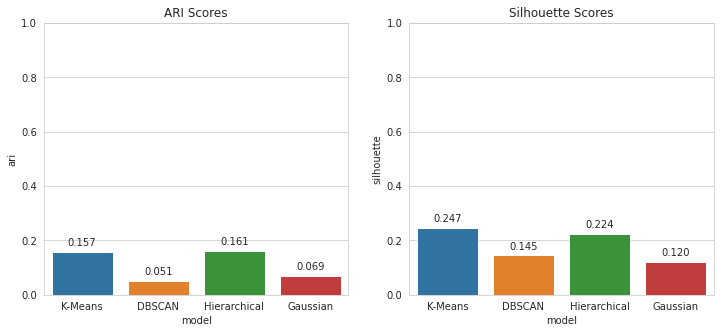

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)

ari_splot = sns.barplot(y=scores_df_gmm.ari,
                        x=scores_df_gmm.model)
for p in ari_splot.patches:
  ari_splot.annotate(format(p.get_height(), '.3f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.title('ARI Scores')
ari_splot.set(ylim=(0,1))

plt.subplot(122)
sil_splot = sns.barplot(y=scores_df_gmm.silhouette,
                        x=scores_df_gmm.model)
for p in sil_splot.patches:
  sil_splot.annotate(format(p.get_height(), '.3f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.title('Silhouette Scores')
sil_splot.set(ylim=(0,1))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


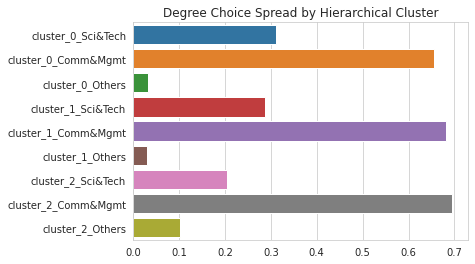

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


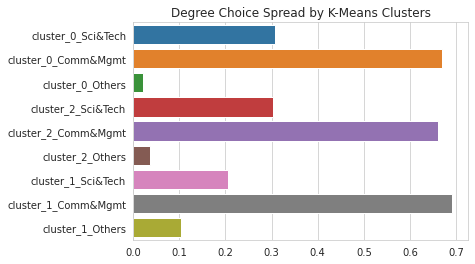

In [ ]:
# Average degree choice by hierarchical cluster
cluster_ratios = {}

for cluster, degree in itertools.product(list(named_data.hierarchical_clusters.unique()),
                                         list(named_data.college_degree.unique())):

    degree_filter = named_data.college_degree == degree
    cluster_filter = named_data.hierarchical_clusters == cluster

    ratio = len(named_data[degree_filter][cluster_filter]) / len(named_data[cluster_filter])

    cluster_ratios['cluster_'+str(cluster)+'_'+degree] = ratio
                          


splot = sns.barplot(y=list(cluster_ratios.keys()),
                    x=list(cluster_ratios.values()))
plt.title('Degree Choice Spread by Hierarchical Cluster')
plt.show()


# Average degree choice by k-means cluster
cluster_ratios = {}

for cluster, degree in itertools.product(list(named_data.kis3_clusters.unique()),
                                         list(named_data.college_degree.unique())):

    degree_filter = named_data.college_degree == degree
    cluster_filter = named_data.kis3_clusters == cluster

    ratio = len(named_data[degree_filter][cluster_filter]) / len(named_data[cluster_filter])

    cluster_ratios['cluster_'+str(cluster)+'_'+degree] = ratio
                          


splot = sns.barplot(y=list(cluster_ratios.keys()),
                    x=list(cluster_ratios.values()))
plt.title('Degree Choice Spread by K-Means Clusters')
plt.show()

It appears that students in one cluster are about 30% less likely to major in Sci & Tech, and major in 'other' subjects instead. Based on the current models, it's not possible to attribute this to the predictive quality of high school / early college grades on major choice versus the correlation between major choice and performance on MBA and employability tests.

## 6.1 T-tests

Text(0, 0.5, 'Distribution')

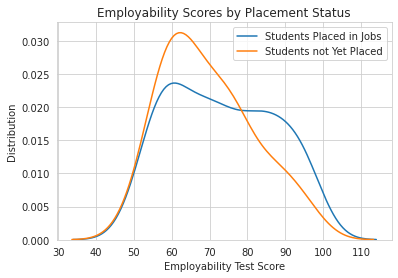

In [ ]:
placed_employability = named_data.percentage_employability_test[named_data.placed_label == 1]
unplaced_employability = named_data.percentage_employability_test[named_data.placed_label == 0]

kplot = sns.kdeplot(placed_employability,
            label='Students Placed in Jobs')
kplot = sns.kdeplot(unplaced_employability,
            label='Students not Yet Placed')
kplot.legend()
plt.title('Employability Scores by Placement Status')
plt.xlabel('Employability Test Score')
plt.ylabel('Distribution')

Text(0.5, 1.0, 'Average Score by Placement Status')

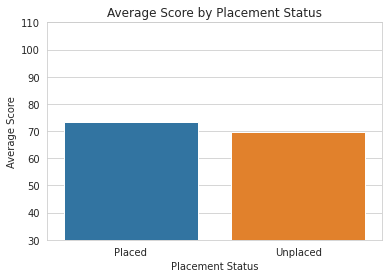

In [ ]:
sns.barplot(y=[placed_employability.mean(),
               unplaced_employability.mean()],
            x=['Placed', 'Unplaced'])
plt.ylim(30,110)
plt.ylabel('Average Score')
plt.xlabel('Placement Status')
plt.title('Average Score by Placement Status')

In [ ]:
tstat, pval, df = (
    # Using ttest_ind from statsmodels for two-sample t-test
    ttest(placed_employability,
          unplaced_employability,
          alternative='two-sided', # Takes alternative hypothesis that 
                                    # difference in means not equal to value.
          usevar='unequal' # Standard deviations of samples not assumed
                            # to be the same.
          ))

(0.0, 0.1)

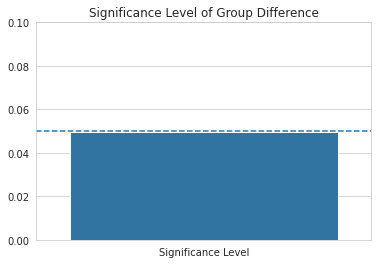

In [ ]:
bplot = sns.barplot(y=[pval],
            x=['Significance Level'])
plt.title('Significance Level of Group Difference')
bplot.axhline(.05, ls='--')
plt.ylim(0,.1)

In [ ]:
named_data.columns

Index(['serial_num', 'gender', 'percentage_9_10_grade',
       'board_of_education_9_10', 'percentage_11_12_grade',
       'board_of_education_11_12', 'college_degree_type', 'percentage_college',
       'college_degree', 'work_experience_label',
       'percentage_employability_test', 'specialisation', 'percentage_mba',
       'placed', 'salary', 'placed_label', 'mba_employability_interaction',
       'kis3_clusters', 'dbscan_clusters', 'hierarchical_clusters',
       'gmm_clusters'],
      dtype='object')

In [ ]:
named_data.work_experience_label.unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
def get_groups(var, label1, label2):

    label1_placed_employability = placed_employability[named_data[var] == label1]
    label2_placed_employability = placed_employability[named_data[var] == label2]
    label1_unplaced_employability = unplaced_employability[named_data[var] == label1]
    label2_unplaced_employability = unplaced_employability[named_data[var] == label2]

    return label1_placed_employability, label1_unplaced_employability, label2_placed_employability, label2_unplaced_employability, 

def var_pvals(var, label1, label2):

    label1_placed_employability = placed_employability[named_data[var] == label1]
    label2_placed_employability = placed_employability[named_data[var] == label2]
    label1_unplaced_employability = unplaced_employability[named_data[var] == label1]
    label2_unplaced_employability = unplaced_employability[named_data[var] == label2]

    _, pval_1, _ = (
        # Using ttest_ind from statsmodels for two-sample t-test
        ttest(label1_placed_employability,
              label1_unplaced_employability#,
            # alternative='two-sided', # Takes alternative hypothesis that 
                                        # difference in means not equal to value.
            # usevar='unequal' # Standard deviations of samples not assumed
                                # to be the same.
              ))

    _, pval_2, _ = (
        # Using ttest_ind from statsmodels for two-sample t-test
        ttest(label2_placed_employability,
              label2_unplaced_employability#,
              #alternative='two-sided', # Takes alternative hypothesis that 
                                        # difference in means not equal to value.
              #usevar='unequal' # Standard deviations of samples not assumed
                                # to be the same.
              ))
    
    return pval_1, pval_2

In [ ]:
exp_pval, noexp_pval = var_pvals('work_experience_label', 'Yes', 'No')

Text(0, 0.5, 'Significance Level')

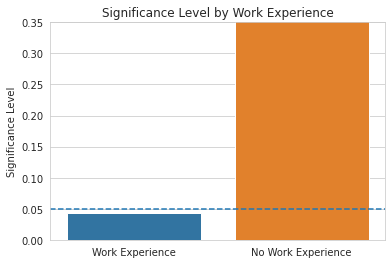

In [ ]:
bplot = sns.barplot(y=[exp_pval, noexp_pval],
            x=['Work Experience', 'No Work Experience'])
plt.title('Significance Level by Work Experience')
bplot.axhline(.05, ls='--')
plt.ylim(0,.35)
plt.ylabel('Significance Level')

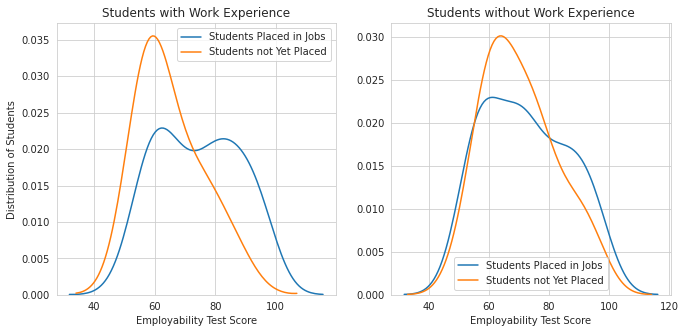

In [ ]:
group1placed, group1unplaced, group2placed, group2unplaced = get_groups('work_experience_label', 'Yes', 'No')

plt.figure(figsize=(11,5))
plt.subplot(121)
kplot = sns.kdeplot(group1placed,
            label='Students Placed in Jobs')
kplot = sns.kdeplot(group1unplaced,
            label='Students not Yet Placed')
kplot.legend()
plt.title('Students with Work Experience')
plt.xlabel('Employability Test Score')
plt.ylabel('Distribution of Students')
plt.subplot(122)
sns.kdeplot(group2placed,
            label='Students Placed in Jobs')
sns.kdeplot(group2unplaced,
            label='Students not Yet Placed')
plt.title('Students without Work Experience')
plt.xlabel('Employability Test Score')
plt.show()

In [ ]:
named_data.specialisation.unique()

array(['Mkt&HR', 'Mkt&Fin'], dtype=object)

In [ ]:
hr_pval, fin_pval = var_pvals('specialisation', 'Mkt&HR', 'Mkt&Fin')

(0.0, 0.35)

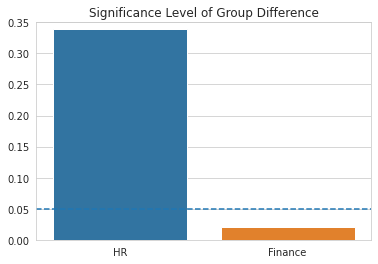

In [ ]:
bplot = sns.barplot(y=[hr_pval, fin_pval],
            x=['HR', 'Finance'])
plt.title('Significance Level of Group Difference')
bplot.axhline(.05, ls='--')
plt.ylim(0,.35)

NameError: ignored

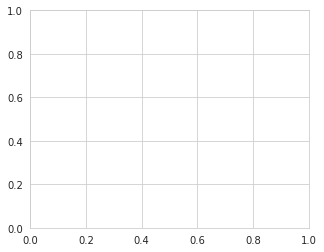

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
sns.kdeplot(hr_placed_employability)
sns.kdeplot(hr_unplaced_employability)
plt.subplot(122)
sns.kdeplot(fin_placed_employability)
sns.kdeplot(fin_unplaced_employability)
plt.show()

In [ ]:
male_pval, female_pval = var_pvals('gender', 'M', 'F')

In [ ]:
bplot = sns.barplot(y=[male_pval, female_pval],
            x=['Men', 'Women'])
plt.title('Significance Level of Group Difference')
bplot.axhline(.05, ls='--')
plt.ylim(0,1)

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
sns.kdeplot(female_placed_emnployability)
sns.kdeplot(female_unplaced_emnployability)
plt.subplot(122)
sns.kdeplot(male_placed_emnployability)
sns.kdeplot(male_unplaced_emnployability)
plt.show()

## 6.2 K-Means on Reduced Group

In [ ]:
reduced = (named_data[named_data.work_experience_label == 'Yes']
                    # [named_data.gender == 'M']
                   #  [named_data.specialisation == 'Mkt&Fin']
           )

# Loading the data from Sklearn's datasets
reduced_X = reduced[['percentage_9_10_grade',
             'percentage_11_12_grade',
             'percentage_college',
             'percentage_employability_test',
             'percentage_mba',
             'mba_employability_interaction']]
reduced_y = reduced.placed_label

# Standarizing the features
scaler = StandardScaler()
reduced_X_scaled = scaler.fit_transform(X)

In [ ]:
k_vals = list(range(2,10))
ari_scores = []
silhouette_scores = []

for k in k_vals:
  labels = KMeans(n_clusters=k, random_state=42).fit_predict(reduced_X_scaled)

  ari_score = metrics.adjusted_rand_score(reduced_y, labels)
  ari_scores.append(ari_score)

  silhouette_score = metrics.silhouette_score(reduced_X_scaled, labels, metric='euclidean')
  silhouette_scores.append(silhouette_score)

sns.set_style('whitegrid')
sns.lineplot(k_vals, ari_scores, label='ARI score')
sns.lineplot(k_vals, silhouette_scores, label='Silhouette score')
plt.legend()

In [ ]:
reduced_k_means_labels = KMeans(n_clusters=7, random_state=42).fit_predict(reduced_X_scaled)

In [ ]:
complete_ari, complete_silhouette = agglomerative_clustering(reduced_X_scaled, 'complete')
average_ari, average_silhouette = agglomerative_clustering(reduced_X_scaled, 'average')
ward_ari, ward_silhouette = agglomerative_clustering(reduced_X_scaled, 'ward')

cluster_nums = [2, 3, 4, 5, 6, 7]

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.lineplot(cluster_nums, complete_ari, label='Complete')
sns.lineplot(cluster_nums, average_ari, label='Average')
sns.lineplot(cluster_nums, ward_ari, label='Ward')
plt.title('ARI Scores for Linkage Types')
plt.legend()

plt.subplot(122)
sns.lineplot(cluster_nums, complete_silhouette, label='Complete')
sns.lineplot(cluster_nums, average_silhouette, label='Average')
sns.lineplot(cluster_nums, ward_silhouette, label='Ward')
plt.title('Silhouette Scores for Linkage Types')
plt.legend()
plt.show()

In [ ]:
ari_scores = []
silhouette_scores = []

clusters = list(range(2,16))

for n_cluster in clusters:
    gmm_labels = GaussianMixture(n_components=n_cluster,
                                 random_state=42).fit_predict(reduced_X_scaled)

    ari_score = metrics.adjusted_rand_score(reduced_y,
                                            gmm_labels)
    ari_scores.append(ari_score)

    silhouette_score = metrics.silhouette_score(reduced_X_scaled,
                                                gmm_labels,
                                                metric='euclidean')
    silhouette_scores.append(silhouette_score)

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.lineplot(clusters, ari_scores)
plt.title('ARI Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI Score')

plt.subplot(122)
sns.lineplot(clusters, silhouette_scores)
plt.title('Silhouette Scores for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
named_data.columns

Index(['serial_num', 'gender', 'percentage_9_10_grade',
       'board_of_education_9_10', 'percentage_11_12_grade',
       'board_of_education_11_12', 'college_degree_type', 'percentage_college',
       'college_degree', 'work_experience_label',
       'percentage_employability_test', 'specialisation', 'percentage_mba',
       'placed', 'salary', 'placed_label', 'mba_employability_interaction',
       'kis3_clusters', 'dbscan_clusters', 'hierarchical_clusters',
       'gmm_clusters'],
      dtype='object')

In [ ]:
# Avg salary per cluster
named_data.salary[named_data.hierarchical_clusters == 2].dropna().mean() / named_data.salary.dropna().mean()

1.0570307756069823